# Adaptive Noise Cancellation
Doctor, in trying to review the electroencephalogram (EEG) of a distracted graduate student, finds that the signal he would like to see has been contaminated by a 60-Hz noise source. He is examining the patient on-line and wants to view the best signal that can be obtained.

In [44]:
import numpy as np
import matplotlib.pyplot as plt
from numpy.linalg import inv
from keras import models
from keras import layers
import time
from keras import optimizers


# Obtain the pure EEG Signal $S(k)$ from the data file *Data_EEG.txt* 

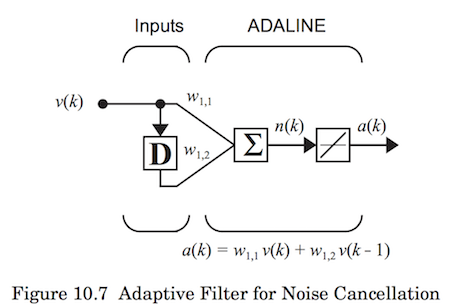

In [45]:
# Architecture of ADALINE of order 1:

from IPython.display import Image
Image("Adaline_Adaptive_Filter.png")

# Objective
The aim of this exercise is to create and train a minimalist neuron network for a simple use case. More precisely, to create a noise-cancelling network for an EEG signal. The strategy adopted is a basic gradient descent for an adaptive set of weights to transform an output signal by removing its interferences.

In [46]:
S= np.loadtxt('Data_EEG.txt',skiprows=1,unpack=True)
S_sqr=np.square(S)
Mean_S_sqr=np.mean(S_sqr)
n=len(S)

# Create the unfiltered signal $t(k)=S(k)+m(k)$ 
- $S(k)$: is the **pure EEG signal**
- $v(k)$: is the sampled sinusoidal electrical network signal (three times in a period) and considered as the input signal to ADALINE network and its output
- $m(k)$:  is the noisy signal comming from the electrical network. 
- $t(k)$: is the unfiltered signal (t(k)=S(k)+m(k))
- $a(k)$: is the estimation of the noisy signal m(k). 
- plot the pure signal $S(k)$ and unfiltered signal $T(k)$ in order to evaluate the filtering operated by ADALINE network.

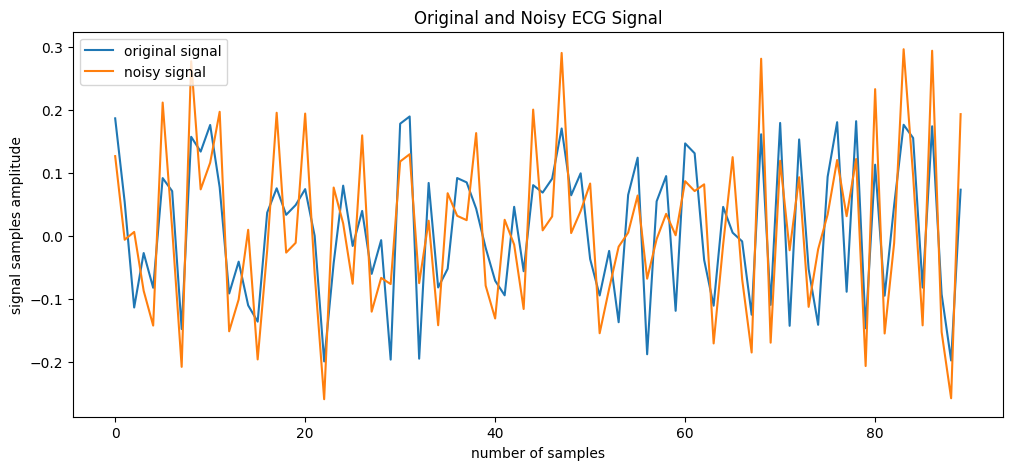

In [47]:
v=[]
m=[]
for i in range(30):
     v=np.concatenate((v,[1.2*np.sin(2*np.pi*(1/3)), 1.2*np.sin(2*np.pi*(2/3)), 1.2*np.sin(2*np.pi*(3/3))]))
     m=np.concatenate((m,[0.12*np.sin((2*np.pi*(1/3))+np.pi/2), 0.12*np.sin((2*np.pi*(2/3))+np.pi/2), 0.12*np.sin((2*np.pi*(3/3))+np.pi/2)]))

# Contaminated output signal    
t=S+m
#..........................
plt.figure(1,figsize=(12,5))
plt.plot(S)
plt.plot(t)
plt.legend(('original signal','noisy signal'),loc='upper left')
plt.title('Original and Noisy ECG Signal')
plt.xlabel('number of samples')
plt.ylabel('signal samples amplitude')
plt.show()

# Filter Order Selection
ADALINE output $a(t)$ may be calculated based on:
- a first order model given in the figure using the mathematical expression: $a(k)=w_{11}v(k)+w_{12}v(k-1)$ 
- a second order model given by  the mathematical expression:  $a(k)=w_{11}v(k)+w_{12}v(k-1)+ w_{13}v(k-2)$

where the order is the number of retarded inputs signals used as input to neural network.

# First Order Filter Design:  Optimal Solution
- The optimal solution is obtained by minimizing **least mean square** (LMS) between 
the unfiltered signal T(k) and the output of the second order filter given 
by $a(k)=w_{11}v(k)+w_{12}v(k-1)$. For more details please **see course slide nr.19**.
- $Min_{(w_{11},w_{12})}\frac{1}{n}\|\sum_1^n(T(k)-a(k))\|$, where $n=dim(T)$
- Let us note: $x=[w_1, b]^T$ and $ z=[v,1]^T \Rightarrow a=x^Tz $ is the ADALINE output
- Solution:  $w=R^{-1}h$ where  $h=E[tz]$ and   $R=E[zz^T]$ 
- In our calculation we have considered that the biais value $b=0$

 



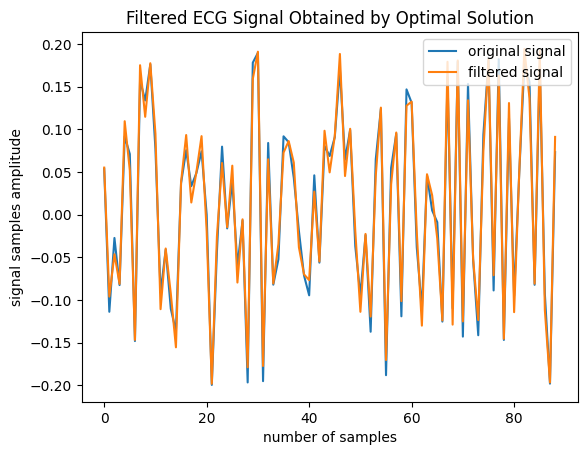

In [48]:
case="1ordre"
if case=='1ordre': # case of third order filter calculation
    n=len(t)-1
    w=np.array([0 , 0]) # initial values of synaptic weights
    b=0                 # initial values of baised value
    a=np.zeros(len(t)-1); # initial value of ADALINE network output
    V=np.array([v[1:90], v[0:89]]) #input signal
    T=t[1:90] # target signal 
    

 # Minimizing the square of difference between target signal and ADALINE network output
# Optimal solution (see course slide nr. 19)
    Cov_R=np.cov(v[1:90], v[0:89])
    Cov_h=np.dot(V,T.T)/len(t[1:])
    w1=np.dot(inv(Cov_R),Cov_h.T)
    a1=np.dot(w1.T,V) # simulate the ADALINE for optimal solution on input signals
    e1=T-a1 # Initial filtered signal values
    
    plt.figure(2)
    plt.plot(S[1:90])
    plt.plot(e1)
    plt.legend(('original signal','filtered signal'),loc='upper right')
    plt.title('Filtered ECG Signal Obtained by Optimal Solution')
    plt.xlabel('number of samples')
    plt.ylabel('signal samples amplitude')
    plt.show()
    e=T-a
    J=[]


# First Order Filter Design: ADALINE Design Based on Iterative Solution 
- The optimal solution is obtained by minimizing **least mean square** (LMS) between the unfiletered signal $T(k)$ considered as target signal and the output of ADALINE network given by $a(k)=w_{11}v(k)+w_{12}v(k-1)$. **For more details please see course slide nr.23**.
- There is no biaised value **b** considered for ADALINE
- Problem: $Min_{(w_{11},w_{12})}\frac{1}{n}\|\sum_1^n(T(k)-a(k))\|$, where $n=dim(T)$ and $a(k)=w_{11}v(k)+w_{12}v(k-1)$
- Problem: $Min_{(w_{11},w_{12})}\frac{1}{n}\|\sum_1^n e(t)\|$, where $n=dim(T)$
- Algorithm:
\begin{eqnarray}
w_i(k+1)&=&w_i(k)+2 \alpha e(k)V^T(k) \nonumber \\
b_i(k+1)&=&b_i(k)+2\alpha e(k)  \nonumber
\end{eqnarray}

# Second Order Filter Design: ADALINE Design based on Iterative Solution 
- The optimal solution is obtained by minimizing least mean square (LMS) between the unfiletered signal $T(k)$ considered as target signal and the output of ADALINE network given by $a(k)=w_{11}v(k)+w_{12}v(k-1)+ w_{13}v(k-2)$.

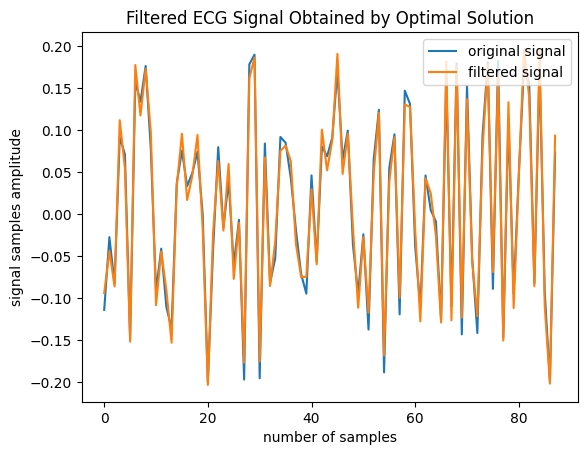

In [49]:
t1s1 = time.perf_counter()

N = 10000
n = len(t) - 2
T=t[2:90] # target signal
V=np.array([v[2:90], v[1:89], v[0:88]]) #input signal
w=np.array([0 , 0, 0]) # initial values of synaptic weights
alpha = 0.001

for i in range(1, N):
  j = np.random.randint(1, n) # création d'un échantillon aléatoire
  J = np.concatenate((J, [j]))
  a = np.dot(w,V)
  s1 = T - a
  w = w + 2*alpha*s1[j]*V[:,j]

final_a = np.dot(w,V)

t2s1 = time.perf_counter()

def plot_result(sig, err):
    plt.figure(2)
    plt.plot(sig)
    plt.plot(err)
    plt.legend(('original signal','filtered signal'), loc='upper right')
    plt.title('Filtered ECG Signal Obtained by Optimal Solution')
    plt.xlabel('number of samples')
    plt.ylabel('signal samples amplitude')
    plt.show()
    
plot_result(S[2:90], s1)


# Filter Design: ADALINE Design based using KERAS
- The optimal solution is obtained by minimizing **least mean square** (LMS) between the unfiltered signal $T(k)$ considered as target signal and the output of ADALINE network. 
- KERAS allow to define optimization algorithms and paremetters


In [50]:
t1_train = time.perf_counter()
N = 1000

model = models.Sequential([
    layers.Dense(1, name="firstLayer")
])

model.compile(loss="mse")
model.fit(x=V.T,y=T,epochs=N)

t2_train = time.perf_counter()

Epoch 1/1000
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.1891  
Epoch 2/1000
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.1744 
Epoch 3/1000
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1684 
Epoch 4/1000
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1606 
Epoch 5/1000
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1554 
Epoch 6/1000
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1570 
Epoch 7/1000
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1518 
Epoch 8/1000
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1460 
Epoch 9/1000
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1485 
Epoch 10/1000
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.1560 
Epoch 11/1000
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1404 
Epoch 12/1000
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.1323 
Epoch 13/1000
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.1283 
Epoch 14/1000
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.1297 
Epoch 15/1000
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1214 
Epo

 # Simulate ADALINE
 - obtain the synaptic weights from network model via **model.get_weights()** and propagate the input signal to the ADALINE output **$a(t)$** using the mathematical expression: $a(k)=w_{11}v(k)+w_{12}v(k-1)$ or  $a(k)=w_{11}v(k)+w_{12}v(k-1)+ w_{13}v(k-2)$ corresponding to first or second order ADALINE flter. 

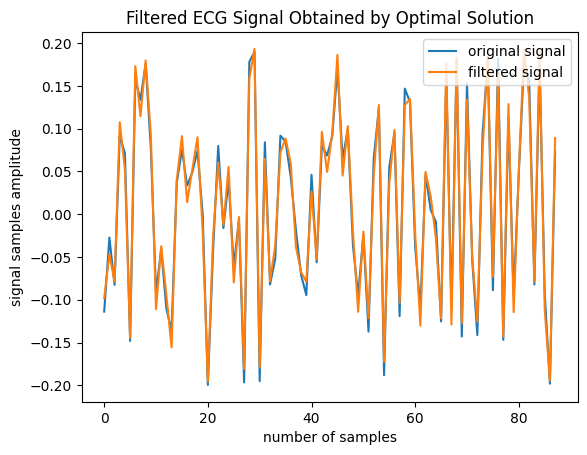

In [51]:
t1s2 = time.perf_counter()

V = np.array([v[2:90], v[1:89], v[0:88]]) #input signal
w = model.get_weights()[0]
w = [w[0][0], w[1][0], w[2][0]]
a = np.dot(w, V)
s2 = T - a

plot_result(S[2:90], s2)

t2s2 = time.perf_counter()

# Simulate ADALINE
 - propagate the input signal using  KERAS command **model.predict(input_NN)** in order to obtain the ADALINE output **$a(t)$**

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 


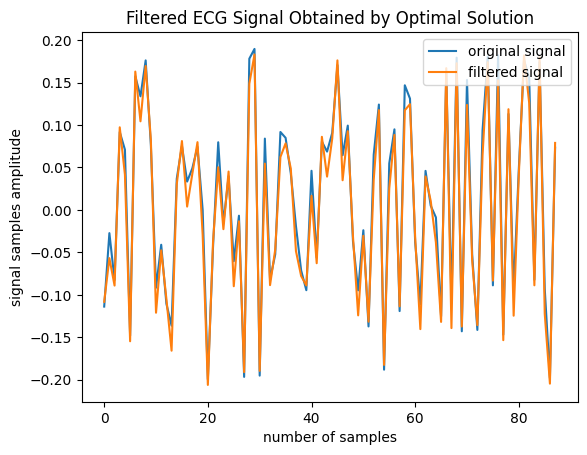

In [52]:
t1s3 = time.perf_counter()

p = model.predict(V.T)[:, 0]
s3 = T - p

plot_result(S[2:90], s3)

t2s3 = time.perf_counter()

# Summary
Because the problematic was quite simple, and even narrowed down, three different approaches could be evaluated. First, the iterative approach recreated the gradient descent principles manually, applying its mathematical formulas at every step, in a custom loop. This approach is only possible in this case thanks to the small amount of weights of the model. In order not to do every calculus and step of the gradient descent by hand, pre-made solutions like KERAS are provided with built-in functions and classes to facilitate a model training. Using this approach, a model with optimized weights is obtained. A first possibility is to extract those weight and manually propagate them to our ADALINE simulation, getting the filtered output, while a simpler approach is to use the KERAS model and make it predict a filtered signal.

# Comparison of the results
After tackling the initial problem with 3 different solutions, the next step is to compare the outputs in order to determine the best approach. There is three factors to take into consideration when comparing these strategies:
1. Execution time
2. Implementation Complexity
3. Result precision

# 1. Execution Time

Execution times were computed according to the `time.perf_counter()` function.

|                | Iterative | Manual Keras      | Automatic Keras  |
|----------------|-----------|-------------------|------------------|
| Execution time | 0.094s    | 33.740s +  0.128s | 33.740s + 0.209s |

It is clear to see that the iterative method has a consequently faster execution time than the method involving the training of a KERAS model (45.6s). Nonetheless, it is worth mentioning that, after the model training, the sole output computation from the KERAS model for its two approaches have a computation time quite close to the iterative method.

In [54]:
time_train = t2_train - t1_train

print('Execution time for approach 1: ', t2s1 - t1s1, 's')
print('Execution time for approach 2: ', time_train, 's (train) + ', t2s2 - t1s2, 's')
print('Execution time for approach 3: ', time_train, 's (train) + ', t2s3 - t1s3, 's')

Execution time for approach 1:  0.09433560003526509 s
Execution time for approach 2:  33.74016000004485 s (train) +  0.12787350011058152 s
Execution time for approach 3:  33.74016000004485 s (train) +  0.20884889992885292 s


# 2. Implementation Complexity

|            | Iterative | Manual Keras | Automatic Keras |
|------------|-----------|--------------|----------------|
| Complexity | Hard      | Medium       | Easy           |

In the iterative solution, mathematical calculations were used. Without having basic knowledge in gradient descent, it can be complicated since the code is only using the `numpy` library.

The manual keras is possible since the model only has 3 weights, but if it had more, the implementation would have been a lot more complex.

The automatic keras was easy to implement thanks to the integrated function `predict`. No calculations were needed because of kera's `train` function.

# 3. Precision Comparison
A means to compare the precision the different approaches' outputs is to compute the average of the difference between the pure EEG signal value and their prediction.

According to this comparison method, the precision of the results are, for the three methods, really close to the expected output. However, we can see that the more precise solution is the iterative method, then the manual KERAS comes quite close, and finally, the automatic KERAS is the least precise.

In [58]:
def precision(s):
    difference = 0
    count = len(s)
    for idx in range(count - 1):
        difference = abs(s[idx] - S[idx+2])
        
    return difference / count

print('Average error of the approach 1: ', precision(s1))
print('Average error of the approach 2: ', precision(s2))
print('Average error of the approach 3: ', precision(s3))

Average error of the approach 1:  3.9387098974920376e-05
Average error of the approach 2:  4.0648650008176523e-05
Average error of the approach 3:  7.44434649294079e-05


# Conclusion
According to the benchmarks, it is safe to say that the iterative approach seems to be the best at handling this specific use case. However, it is not a flexible nor a scalable approach for generalizing neural network computation. The KERAS library makes implementing such solutions in just a few lines of code and without having to enter to specific mathematical calculations. As the range of different problematics that can be tackled with neural network and deep learning is so big, it is very important to provide fast and efficient solutions for researchers to use and build from.

As the KERAS approaches scored less in the time benchmarks and the precision benchmark, it is safe to say that the competition was very close.